# Entraîner un réseau Unet

Dans ce TD, nous allons créer et entraîner un réseau de neurones convolutionnel de type Unet. L'objectif est d'identifier les zones de cirrus et de cumulus sur une photo.

Le Unet permet de segmenter des images, en classifiant chaque pixel dans une catégorie.

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
import matplotlib.image as mpimg
import csv
import json
import random
from skimage.transform import resize

import keras
from keras import callbacks
from keras.models import *
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, concatenate
from keras.optimizers import *

from keras import backend as keras_backend

/home/simon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#exclude
num_label = 6
images_dir = './data/'
labels_filename = "via_region_data.csv"
nb_y_features = 7

width = 320
height = 240

In [1]:
a=2

In [2]:
a

2

## Annoter les images d'entraînement

Nous allons d'abord labelliser le jeu d'entraînement. Pour cela, nous allons utiliser l'outil VGG Image Annotator (VIA) pour délimiter chaque zone de nuage par un polygone.

Dans VIA, les polygones sont groupés par type, et portent chacun un label. Nous allons utiliser les noms suivants :
* Type : nuages
* Labels :
  * cirrus
  * cumulus

Lien de téléchargement de l'outil VIA :
http://www.robots.ox.ac.uk/~vgg/software/via/

Une fois les images annotées, récupérer les données sous forme d'un csv et le placer dans le dossier data.

## Lecture des données du fichier csv produit par VIA

Commençons par lire le fichier csv créé à l'aide de VGG Image Annotator. Nous allons mettre le contenu de ce fichier dans une liste `labels_data` dont chaque élément contient les informations suivantes :
* nom de fichier
* label
* coordonnées du polygone

In [3]:
# Lit le fichier csv créé à l'aide de VGG Image Annotator
# et créée une liste labels_data dont chaque élément contient les informations suivantes :
# nom de fichier, label, coordonnées du polygone

labels_data = []

with open(labels_filename) as csvfile:
    csvreader = csv.DictReader(csvfile)
    i = 0
    for row in csvreader:
        filename = row['filename']
        try:
            all_points_x = json.loads(row['region_shape_attributes'])['all_points_x']
            all_points_y = json.loads(row['region_shape_attributes'])['all_points_y']
            # Récupère les polygones de neige
            label = json.loads(row['region_attributes'])['Chess']
            
            # Add data to list
            labels_data.append({
                'filename': filename,
                'all_points_x': all_points_x,
                'all_points_y': all_points_y,
                'label': label
            })
            
            # Count data
            i += 1

        except KeyError:
            all_points_x = []
            all_points_y = []
            label = ""
print (i, "data found.")
print ("labels_data list created.")

668 data found.
labels_data list created.


Regardons à quoi ressemble un élément de la liste labels_data.

## Création des masques

En sortie, le Unet va produire des masques contenant, pour chaque pixel, une valeur entre 0 et 1 indiquant la probabilité d'appartenance à la classe.

Dans notre exemple, le Unet va produire un masque pour les cirrus et un autre pour les cumulus.

Il faut donc créer ces masques à partir des polygones.

Commençons par écrire une fonction qui génère un masque sous la forme d'un matrice numpy à partir d'un polygone.

In [6]:
# Function to plot a polygon on a mask
# Input : list of points (x and y), width and height of the mask
# Returns a numpy array (0 for points out of the polygon, 1 for points in the polygon)
def create_mask_polygon(all_points_x, all_points_y, width, height):
    mask_shape = (height, width)
    points = np.indices(mask_shape).reshape(2, -1).T
    verts = np.array((all_points_y, all_points_x)).T
    path = Path(verts)
    mask = path.contains_points(points, radius=1e-9)
    mask = mask.reshape(mask_shape).astype('int')
    return mask

Créons maintenant un masque pour chaque polygone de labels_data, et mettons le résultat dans labels_data.

In [7]:
# Create masks in labels_data
for elt in labels_data:
    # Get data
    all_points_x = elt['all_points_x']
    all_points_y = elt['all_points_y']
    img_path = images_dir + elt['filename']
    img = mpimg.imread(img_path)
    img_height = img.shape[0]
    img_width = img.shape[1]
    # Plot polygon on mask
    mask = create_mask_polygon(np.array(all_points_x) * width / img_width, np.array(all_points_y) * height / img_height, width, height)
    #mask = create_mask_polygon(np.array(all_points_x), np.array(all_points_y), img_width, img_height)
    elt['mask'] = mask

Visualisons une image et un masque.

/home/simon/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


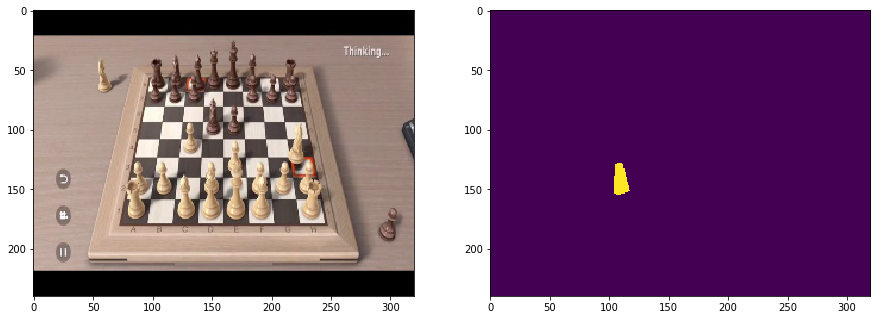

In [8]:

f,ax = plt.subplots(1,2, figsize=(15, 8))

mask = labels_data[num_label]['mask']

img = mpimg.imread(images_dir + labels_data[num_label]['filename'])

img = resize(img, (height, width))

ax[0].imshow(img)
ax[1].imshow(mask)
plt.show()

Chaque polygone a maintenant son masque. Nous pouvons donc préparer le jeu de données sous la forme X, y.

Attention, chaque image peut avoir plusieurs polygones. Dans ce cas, il faut fusionner les masques de chaque polygone.

In [9]:
### Create X and y dataset


### Create filename list

filenames = []

for elt in labels_data:
    filename = elt['filename']
    if filename not in filenames:
        filenames.append(filename)
    
### Create X and y dataset

X = []
y = []
for filename in filenames:
    # Load image
    image = mpimg.imread(images_dir + filename)
    image = resize(image, (height, width))
    X.append(image)
    
    # Load masks
    zero_mask = np.zeros((height, width))
    masks = [zero_mask for i in range(nb_y_features)]
    for elt in labels_data:
        if elt['filename'] == filename:
            if elt['label'] == 'board':
                masks[0] = np.logical_or((masks[0] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'queen':
                masks[1] = np.logical_or((masks[1] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'king':
                masks[2] = np.logical_or((masks[2] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'pawn':
                masks[3] = np.logical_or((masks[3] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'bishop':
                masks[4] = np.logical_or((masks[4] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'knight':
                masks[5] = np.logical_or((masks[5] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'tower':
                masks[6] = np.logical_or((masks[6] > 0), (elt['mask'] > 0)).astype('int')
                
    # Replace empty masks by zeros mask
    for i in range(0,nb_y_features):
        if masks[i] is None:
            masks[i] = np.zeros((height, width))
    y.append(masks)

X = (np.array(X) * 255).astype(np.uint8)
y = np.array(y).swapaxes(1,3).swapaxes(1,2).astype(np.uint8)

/home/simon/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Vérifions que X et y sont corrects

Regardons les dimensions de X et y.

In [10]:
X.shape

(32, 240, 320, 3)

In [11]:
y.shape

(32, 240, 320, 7)

In [12]:
np.save('X.npy', X)
np.save('y.npy', y)

Affichons un élément du jeu de données.

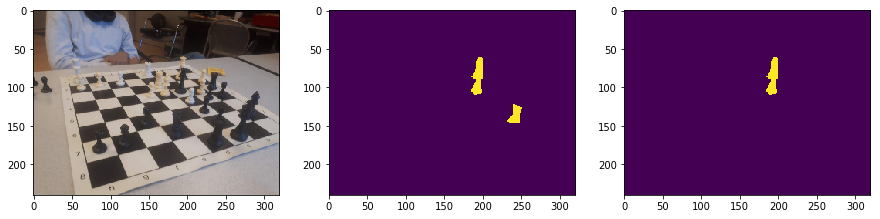

In [42]:
sample_number = 5

f,ax = plt.subplots(1,3, figsize=(15, 8))

img = X[sample_number]
mask_discontinue = y[sample_number, :, :, 3]
mask_continue = y[sample_number, :, :, 1]

ax[0].imshow(img)
ax[1].imshow(mask_discontinue)
ax[2].imshow(mask_continue)
plt.show()

OK. Tout a l'air bon !

## Création de train / val

Découpons le jeu de données en train / val.